<a href="https://colab.research.google.com/github/JD-man/GAN_Study/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN

### 동기
- 지금까지의 GAN은 학습하는 샘플의 종류를 조정할 수 있지만, GAN이 생성하는 샘플의 특징은 지정할 수 없다.
- CGAN은 원하는 데이터를 생성하게 만드는 초기 GAN 혁신 중 하나이다.

### CGAN 소개
- CGAN은 생성자와 판별자가 훈련하는 동안 추가 정보를 사용해 조건이 붙는 생성적 적대 신경망이다.
- 추가 정보는 클래스 레이블, 태그, 글로 쓰인 설명도 가능하다.

### 생성자
- 조건 레이블 y, 잡음 벡터 z를 입력으로 받아 가짜샘플을 만든다. G(z,y) = x<sup>*</sup>|y  

### 판별자
- 진짜 샘플과 레이블 (x,y)과 가짜 샘플과 레이블 (x<sup>*</sup>|y, y)를 받는다.
- 진짜 샘플-레이블 쌍으로 판별자는 진짜 데이터를 구별하고 그에 맞는 쌍을 판별하는 법을 배운다.
- 생성자가 만든 샘플에서는 가짜 이미지-레이블 쌍을 판별하는 법을 배운다.
- 판별자는 입력이 진짜이고 올바른 쌍인지를 나타내는 하나의 확률을 출력한다.
- 판별자의 목표는 모든 가짜 샘플과 맞지 않는 모든 샘플을 가려내고 모든 진짜 샘플 - 레이블 쌍은 받아들이도록 학습하는것.

### 구조 다이어그램
- 생성자는 z와 y를 받아 (x<sup>*</sup>|y,y)를 생성
- 판별자는 (x<sup>*</sup>|y,y)와 훈련 데이터셋 (x,y)를 받아 확률을 출력

# CGAN 구현하기
- 선택한 손글씨 숫자를 생성하는 CGAN 모델을 구현한다.

### 구현
- Embedding층으로 샘플과 레이블을 은닉층의 표현으로 연결한 기법을 사용한다.
- 합성곱 신경망을 적용하여 더 실제 같은 샘플을 만들도록 한다.

In [ ]:
# 모듈과 라이브러리 임포트

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam                                  

In [ ]:
# 모델 입력 차원

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

# CGAN 생성자

- 임베딩과 원소별 곱셈을 사용해 랜덤 잡음 벡터 z와 레이블 y를 하나의 표현으로 합친다.
 1. 레이블 y(0~9)를 받아 케라스 Embedding 층으로 z_dim 크기의 밀집 벡터로 변환한다.
 2. 케라스 Multiply 층으로 레이블 임베딩과 잡음 벡터 z를 합친다. 곱셈 결과로 하나의 벡터를 출력한다.
 3. 이 결과 벡터(조인트 표현)를 생성자 네트워크의 입력으로 주입한다.

In [ ]:
def build_generator(z_dim):
  model = Sequential()

  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7,7,256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
  model.add(Activation('tanh'))
  return model

def build_cgan_generator(z_dim):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,), dtype='int32')

  # 레이블을 z_dim 크기의 밀집 벡터로 변환. 크기는 (batch_size, 1, z_dim)이다.
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
  # 위의 3D 텐서를 2D로 변환한다. 크기는 (batch_size, z_dim)
  label_embedding = Flatten()(label_embedding)
  # z와 레이블 임베딩의 원소별 곱셈
  joined_representation = Multiply()([z, label_embedding])

  generator = build_generator(z_dim)

  # 주어진 조인트 표현에 대한 생성된 이미지
  conditioned_img = generator(joined_representation)

  # (입력, 출력)을 가지는 모델을 반환
  return Model([z, label], conditioned_img)
  

# CGAN 판별자

- Embedding 층을 사용해 입력 레이블을 밀집 벡터로 변환
- 생성자와 달리 3D 입력을 받는다.

1. 레이블을 받아 케라스 Embedding층으로 784 크기 밀집 벡터로 변환한다.
2. 레이블 임베딩을 이미지 차원(28 X 28 X 1)로 바꾼다.
3. 크기를 바꾼 레이블 임베딩을 이에 상응하는 이미지와 연결하여 28 X 28 X 2 크기의 표현으로 합친다.
4. 이미지-레이블 조인트 표현을 CGAN 판별자 네트워크의 입력으로 주입한다. 모델의 입력차원은 28 X 28 X 2가 되어야 한다.
5. 첫번째 합성곱 층의 깊이를 32에서 64로 늘린다. 임베딩 때문에 인코딩할 정보가 많기 때문이다.
6. 출력층에는 시그모이드 함수를 사용해 이미지-레이블 쌍이 진짜일 확률을 출력


In [ ]:
def build_discriminator(img_shape):
  model = Sequential()

  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1), padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.01))
  
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  return model

def build_cgan_discriminator(img_shape):
  img = Input(shape=img_shape)
  label = Input(shape=(1,), dtype='int32')
  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
  label_embedding = Flatten()(label_embedding)
  label_embedding = Reshape(img_shape)(label_embedding)
  concatenated = Concatenate(axis=-1)([img, label_embedding])
  discriminator = build_discriminator(img_shape)
  classification = discriminator(concatenated)
  return Model([img, label], classification)

In [ ]:
# 모델 생성

def build_cgan(generator, discriminator):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,))
  img = generator([z, label])
  classification = discriminator([img, label])
  model = Model([z,label], classification)
  return model

In [ ]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

generator = build_cgan_generator(z_dim)

discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
discriminator.summary()
generator.summary()
cgan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        input_8[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

# CGAN 훈련 알고리즘

1. 판별자 훈련  
 a. 진짜 샘플과 레이블의 랜덤한 미니배치 (x,y)를 받는다.  
 b. 미니배치에 대한 D((x,y))를 계산하고 이진 분류 손실을 역전파하여 파라미터를 업데이트하고 손실을 최소화한다.  
 c. 생성자는 랜덤 잡음 벡터와 클래스 레이블의 미니배치 (z,y)를 받고 가짜 샘플의 미니배치 G(z,y) = x<sup>*</sup>|y를 생성한다.  
 d. 미니배치에 대해 D(x<sup>*</sup>|y, y)를 계산하고 이진 분류 손실을 역전파하여 판별자 파라미터를 업데이트하고 손실을 최소화 한다.
2. 생성자 훈련  
 a. 랜덤 잡음 벡터와 클래스 레이블의 미니배치 (z,y)를 받고 가짜 샘플의 미니배치 G(z,y) = x<sup>*</sup>|y를 생성한다.    
 b. 주어진 미니배치에 대한 D(x<sup>*</sup>|y, y)를 계산하고 이진 분류 손실을 역전파하여 생성자 파라미터를 업데이트하고 손실을 최대화 한다.


In [ ]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
  (X_train, y_train), (_, _) = mnist.load_data()

  X_train = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis = 3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, z_dim))

    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration + 1) % sample_interval == 0:
      print("%d [D loss : %f, acc : %.2f%%] [G loss : %f]" % (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])
      sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  labels = np.arange(0,10).reshape(-1, 1)
  gen_imgs = generator.predict([z, labels])
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(10,4),
                          sharey=True,
                          sharex=True)
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i,j].axis('off')
      axs[i,j].set_title("Digit : %d" % labels[cnt])
      cnt+=1

1000 [D loss : 0.715500, acc : 50.00%] [G loss : 0.577089]
2000 [D loss : 0.708434, acc : 40.62%] [G loss : 0.617620]
3000 [D loss : 0.711417, acc : 21.88%] [G loss : 0.659639]
4000 [D loss : 0.696329, acc : 59.38%] [G loss : 0.697818]
5000 [D loss : 0.701023, acc : 21.88%] [G loss : 0.681592]
6000 [D loss : 0.666312, acc : 84.38%] [G loss : 0.729987]
7000 [D loss : 0.681386, acc : 78.12%] [G loss : 0.691578]
8000 [D loss : 0.699330, acc : 32.81%] [G loss : 0.669444]
9000 [D loss : 0.654990, acc : 92.19%] [G loss : 0.734937]
10000 [D loss : 0.639565, acc : 87.50%] [G loss : 0.770774]
11000 [D loss : 0.608120, acc : 90.62%] [G loss : 0.803018]
12000 [D loss : 0.671832, acc : 65.62%] [G loss : 0.749138]
13000 [D loss : 0.687495, acc : 53.12%] [G loss : 0.715280]
14000 [D loss : 0.644036, acc : 76.56%] [G loss : 0.752386]
15000 [D loss : 0.635493, acc : 57.81%] [G loss : 0.699110]
16000 [D loss : 0.641204, acc : 59.38%] [G loss : 0.738257]
17000 [D loss : 0.688200, acc : 54.69%] [G loss :

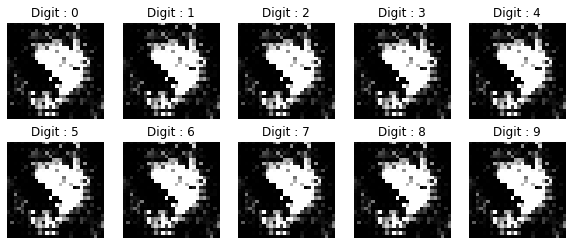

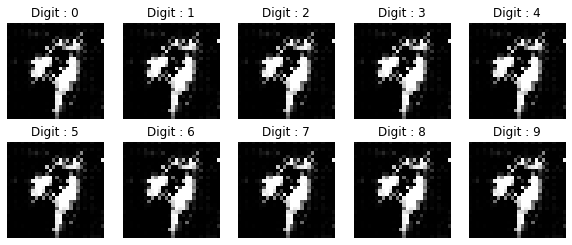

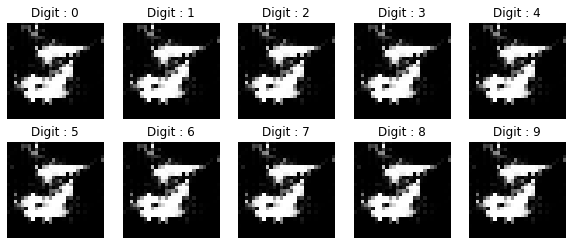

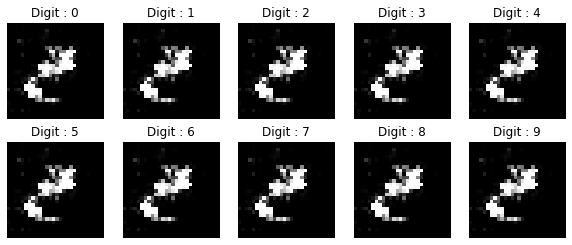

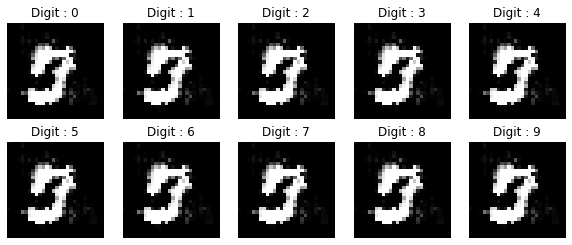

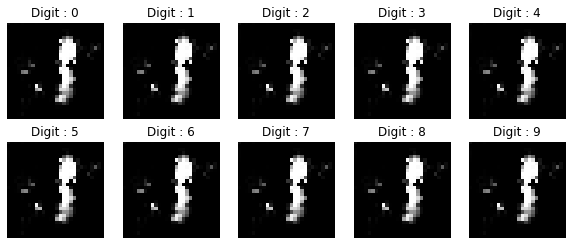

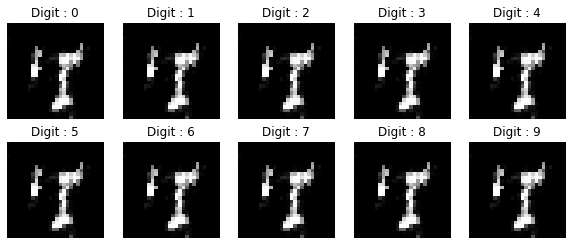

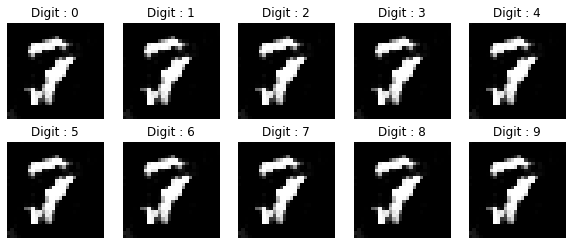

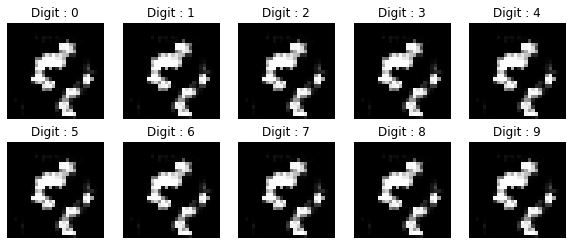

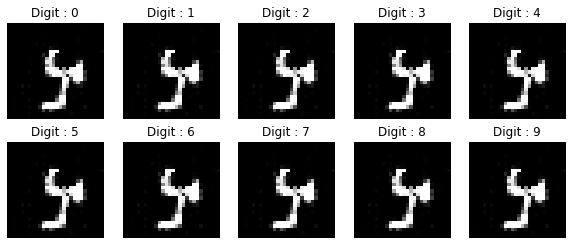

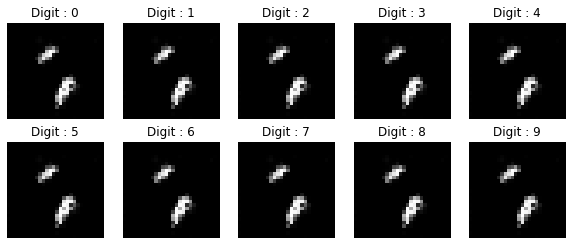

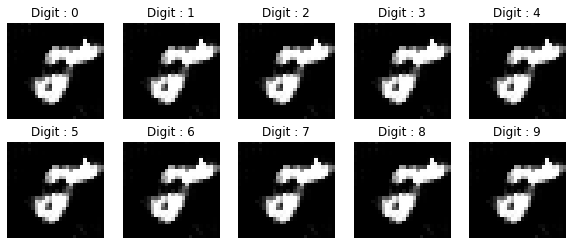

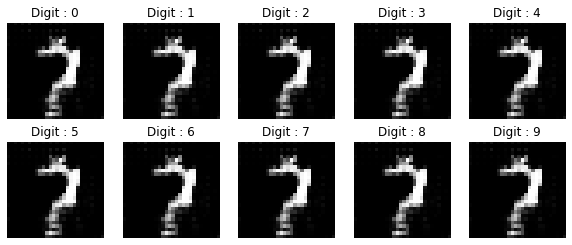

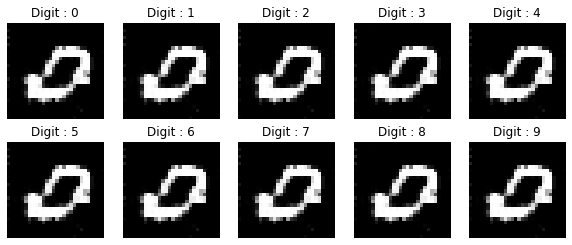

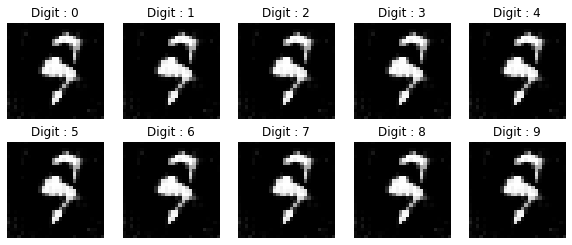

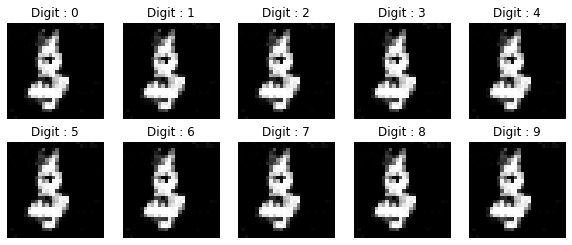

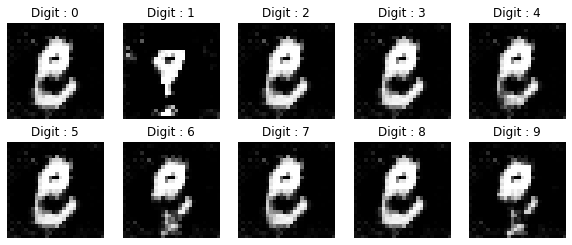

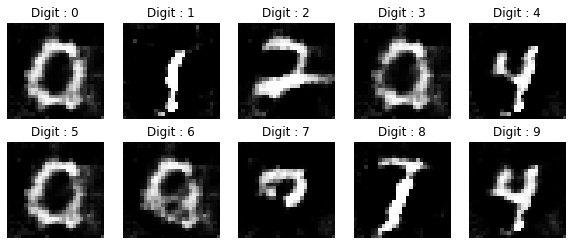

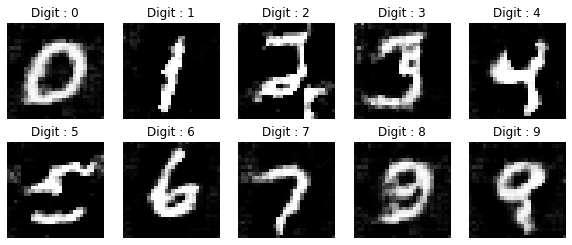

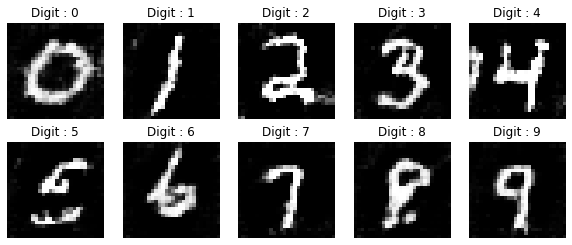

In [ ]:
iterations = 20000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)

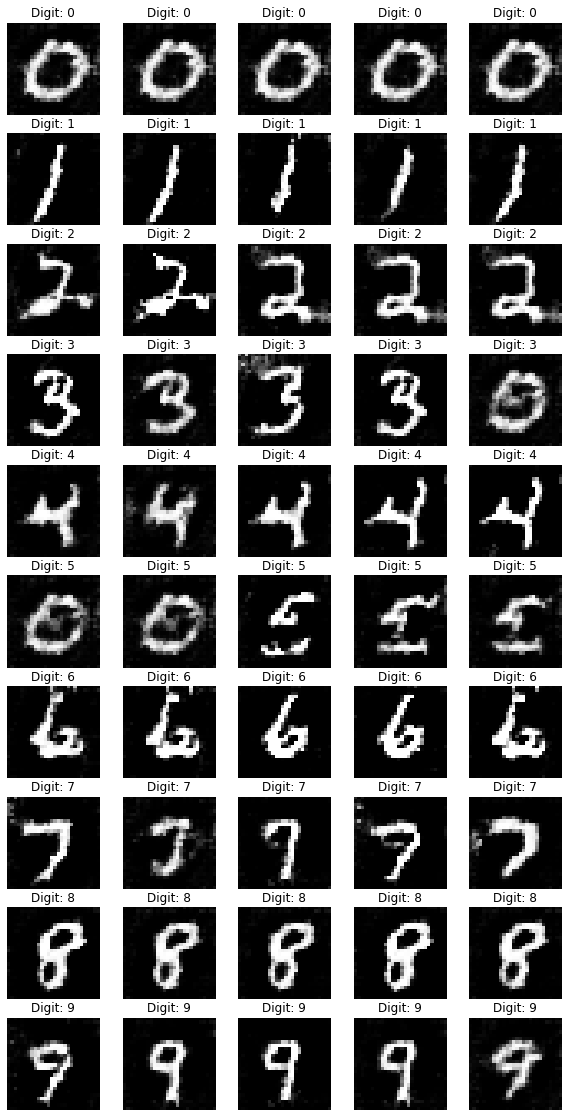

In [39]:
# 그리드 차원을 설정합니다.
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음을 샘플링합니다.
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비합니다.
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성합니다.
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정합니다.
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # 이미지 그리드를 출력합니다.
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1

In [ ]:
# test = np.array([[i for j in range(5)] for i in range(10)])
# print(test)

test = np.array([[i for j in range(5)] for i in range(10)])
print(test)
print(test.shape)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]
 [6 6 6 6 6]
 [7 7 7 7 7]
 [8 8 8 8 8]
 [9 9 9 9 9]]
(10, 5)
